In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/student-lifestyle-dataset/student_lifestyle_dataset.csv


### Imports

In [39]:
pip install summarytools

Note: you may need to restart the kernel to use updated packages.


In [40]:
import pandas as pd
import numpy as p

from summarytools import dfSummary

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

### Data

In [41]:
df = pd.read_csv('/kaggle/input/student-lifestyle-dataset/student_lifestyle_dataset.csv', index_col = 'Student_ID')
df.head(3)

,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
Student_ID,,,,,,,
1,6.9,3.8,8.7,2.8,1.8,2.99,Moderate
2,5.3,3.5,8.0,4.2,3.0,2.75,Low
3,5.1,3.9,9.2,1.2,4.6,2.67,Low


In [42]:
df.isnull().sum()

Study_Hours_Per_Day                0
Extracurricular_Hours_Per_Day      0
Sleep_Hours_Per_Day                0
Social_Hours_Per_Day               0
Physical_Activity_Hours_Per_Day    0
GPA                                0
Stress_Level                       0
dtype: int64

In [43]:
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Study_Hours_Per_Day[float64],Mean (sd) : 7.5 (1.4)min < med < max:5.0 < 7.4 < 10.0IQR (CV) : 2.4 (5.3),51 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/xnp5ZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACh0lEQVR4nO3bS46iUBiG4f+0N7wEY0x05gY66YFDFtGL7SXUwBW4A2cmxmCki4hIj2rWsQRE+PB9xnWqTuAN54ekXJZlBjTdj7o3ADyiW/cG7nHODc2sX3D5Jcuyz2fuB/VpbKjOueF8Pv/t+/6syPrT6XR0zv0h1nZobKhm1vd9fxYEwed0Oo3zLAzD0NtsNrPD4dA3M0JtgSaHamZm0+k0XiwWfwssHZb5u4wd+VV5zRofah0YO/Kr+poR6v8xduRX6TUj1DvqGjuUVXXNWhtqmqY9M/Odc0WW+7fbrffkLb1EW2frVoYaRVEvSZJfq9Wq0+l0ch1DZmZJknhpmv6M4/jDzIo8HWrR5tm6laFeLpeu53mj9XodL5fLY971u91utt1uR9frtVPF/u4p+UT0J5PJIgiCU9tm61aG+mU8Hheal47HYy0zZtkn4tdJMBgMPto2W7c6VEGF35zN6j0JqlZpqGWPMdUXmrKKvjnXdRK8QmWhPusYU3uhQTWqfKJyjIlp8ie9ymfUdzzGStzw2sadpn/S+zbUEnPmW86YZW54neNO0z/p3Q21zJz5rjNmmRvehHGnqZ/0vnuiFp4zm3DR61TkhiuPO1V7aEYtMmdy0fFM/HMfJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJHQf+aEwDL28v/h8PntmZlEUefv9fvTK9ap/W3XfZdc/0tc/7OCg+9Bl+8YAAAAASUVORK5CYII="">",0(0.0%)
2,Extracurricular_Hours_Per_Day[float64],Mean (sd) : 2.0 (1.2)min < med < max:0.0 < 2.0 < 4.0IQR (CV) : 2.0 (1.7),41 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/xnp5ZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACs0lEQVR4nO3csU7bQBzH8f81BB2JZCsQhY0XQOqAxMIDdOzD9hE6MHTOG7AhoSgRKVac4E5V26VJ7mx8v8v3s19syV/bh++Ea5rGgNR96vsEgEOc9X0COXLOXZjZeeDwTdM0b22eTw4ItWXOuYurq6uvRVFMQsavVquFc+4bsf6LUNt3XhTF5OHh4a0sy+qYgcvl0j8+Pk5eXl7OzYxQ/0KoHSnLsprNZj8Dhl60fjIZ4I8pSCBUSCBUSCBUSCBUSCBUSCBUSEj6O2qfS5ERxy7e39+HocdV1uX1SjbUPpciY45d17Xf7Xa3VVV9N7OQD/69iQzNX15efinLchwyeN/1SjZU63cpMvjYT09Pk/l8Ptput4OA4/Ym9sFQ17U3s9v7+/sf0+l0dczYQ65XyqGaWb9LkSHHXiwWqkugwTen2Z8b1Htfd3G9Og018lVysnO9PoU+GLq+QTsLtY1XiepcD+3r8onayqtEba4Xa7fbDc2scM6F/kSWG687n6Om+ipJ0Xq9HtZ1/fnm5mYwGAyOvrnN8t14vTdUvid+nM1mc+a9H93d3VXX19eLY8fnvPH6v6Ge6vfEvo3H49AvHWaZbrze90Q9ue+JSNNBc9QT+56IBLEpBRIIFRIIFRIIFRIIFRIIFRIIFRKS348aKnJzB8u/icky1NjNHSz/pifLUGM3d7D8m54sQ/0tdHMHy7/pyTrUUxQxN096Xk6oGYmZm6c+LyfUjMTMzVOflxNqhkLm5qnPy/ngDwmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgkH/Te/5XLpj/3h19dXb2a2Xq/98/Pz6CPHqx5b9bxjxx/S1y9v7ZrJiLSajwAAAABJRU5ErkJggg=="">",0(0.0%)
3,Sleep_Hours_Per_Day[float64],Mean (sd) : 7.5 (1.5)min < med < max:5.0 < 7.5 < 10.0IQR (CV) : 2.6 (5.1),51 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuNSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/xnp5ZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACo0lEQVR4nO3au24aQRiG4X/CQQNIu8Ig6LgBSymQaLiAlLnYXEIKitTcAR0SQiCIEcshlUtzmGGz+8H7tPaYlf16/hlsdz6fDSi7b0U/AHCLatEPgOfhnGuYWT1w+f58Pn989UFCxUM45xqdTudnkiTtkPXr9XrpnPv1VayEikepJ0nSHo/HH2ma7u5ZuFqt/GQyaS8Wi7qZESryl6bprtfr/Q1Y2rj0QS5TkMCOWjKRFxKzK5cSVYRaIrEXErPrlxJVuYbK7nC34AuJ2W2XElW5hcruEC7iQmJ25VKiKs8d9WV3h4hJkpxOp9qjn+cZ5H5GfbXdIWaSZFnmj8fj+263+21mod+zp1Tqy9TxeKyZWeKcC1le1Pk2eJLMZrP2dDptHg6HSl4Pp+pqqEWNse12W8uy7PtgMKhUKpW7jw5Fn29DJslyuSx0gkRefnM9tlwMtcgxtt/vq9775nA43PX7/eU9ax9xvlU9Z0ZMIf/29vYjTdNWyOvmfWy5tqMWPsZarVYuf5K7RPWcGTOFsizzZvY+Go3+dLvd9b2vnfex5aYzquIYi1T4L2iImCn0+dze+yxkY8j7513qy1SMyItYcjqdammaLhV/QUOmUBme+5KnDDX2IsbbROXzlKHGjEAz3iYqo6cM9VPoRazsY/AV8f+okECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokFC95ZNWq5W/9wtvNhtvZrbdbv18Pm/+z/Wqr6363LHrb+nrH0f+mrbcostgAAAAAElFTkSuQmCC"">",0(0.0%)
4,Social_Hours_Per_Day[float64],Mean (sd) : 2.7 (1.7)min < med < max:0.0 < 2.6 < 6.0IQR (CV) : 2.9 (1.6),61 distinct values,"<img s

### Visuals

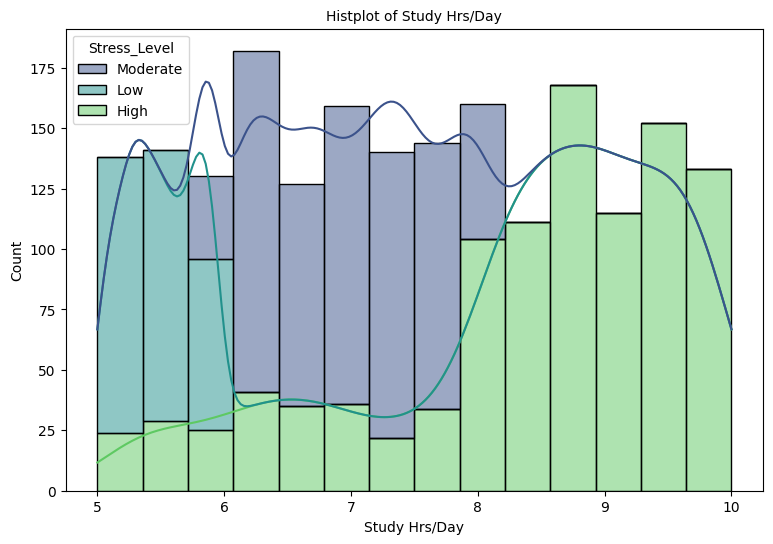

In [44]:
plt.figure(figsize=(9,6))

plt.xlabel("Study Hrs/Day", fontsize=10)
plt.ylabel("Count", fontsize=10)

plt.title("Histplot of Study Hrs/Day", fontsize=10)

sns.histplot(data = df, x='Study_Hours_Per_Day', kde=True, palette='viridis', hue='Stress_Level', multiple='stack')

plt.show()

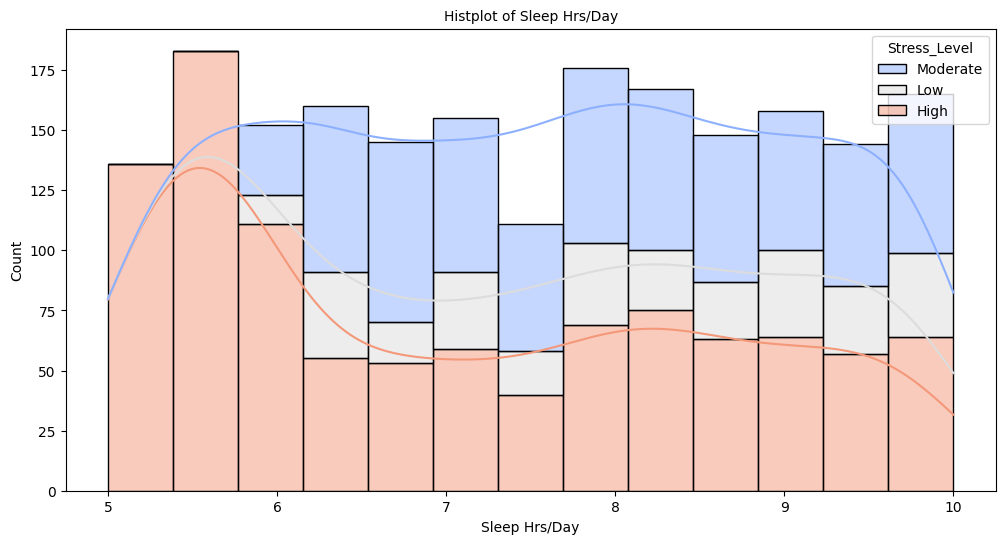

In [45]:
plt.figure(figsize=(12,6))

plt.xlabel("Sleep Hrs/Day", fontsize=10)
plt.ylabel("Count", fontsize=10)

plt.title("Histplot of Sleep Hrs/Day", fontsize=10)

sns.histplot(data=df, x="Sleep_Hours_Per_Day", kde=True, palette='coolwarm', hue='Stress_Level', multiple='stack')

plt.show()

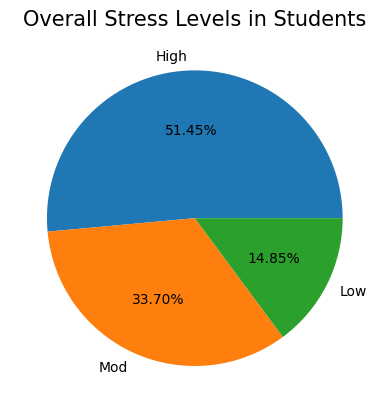

In [46]:
high_stress = df[df['Stress_Level'] == 'High']['Stress_Level'].count()
mod_stress = df[df['Stress_Level'] == 'Moderate']['Stress_Level'].count()
low_stress = df[df['Stress_Level'] == 'Low']['Stress_Level'].count()

index_values = [high_stress, mod_stress, low_stress]
index_labels = ['High', 'Mod', 'Low']

plt.pie(index_values, labels = index_labels, autopct='%2.2f%%')

plt.title('Overall Stress Levels in Students', fontsize=15)

plt.show()

<Figure size 600x600 with 0 Axes>

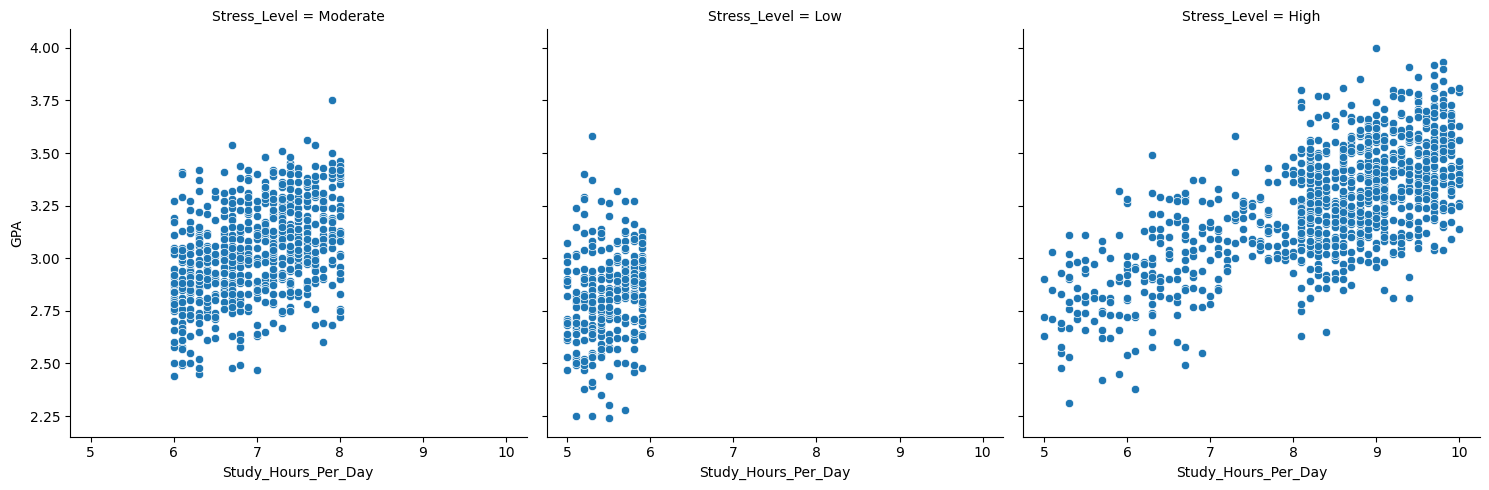

In [47]:
plt.figure(figsize=(6,6))
sns.relplot(df, x="Study_Hours_Per_Day", y="GPA", col="Stress_Level")

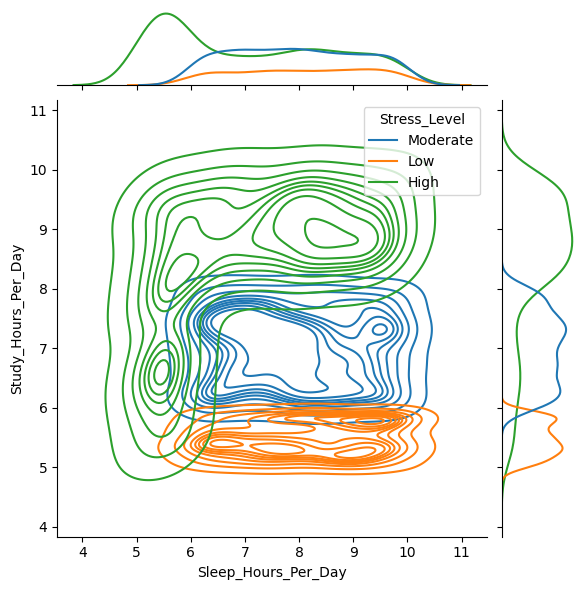

In [48]:
sns.jointplot(
    df,
    x="Sleep_Hours_Per_Day", y="Study_Hours_Per_Day", hue="Stress_Level",
    kind="kde"
)

#### Encoding

In [49]:
df2 = df.copy()

In [50]:
df2['Stress_Encoded'] = LabelEncoder().fit_transform(df2['Stress_Level'])
#df['Stress_Encoded']
df2.head(3)

,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level,Stress_Encoded
Student_ID,,,,,,,,
1,6.9,3.8,8.7,2.8,1.8,2.99,Moderate,2
2,5.3,3.5,8.0,4.2,3.0,2.75,Low,1
3,5.1,3.9,9.2,1.2,4.6,2.67,Low,1


In [51]:
df.head(3)

,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
Student_ID,,,,,,,
1,6.9,3.8,8.7,2.8,1.8,2.99,Moderate
2,5.3,3.5,8.0,4.2,3.0,2.75,Low
3,5.1,3.9,9.2,1.2,4.6,2.67,Low


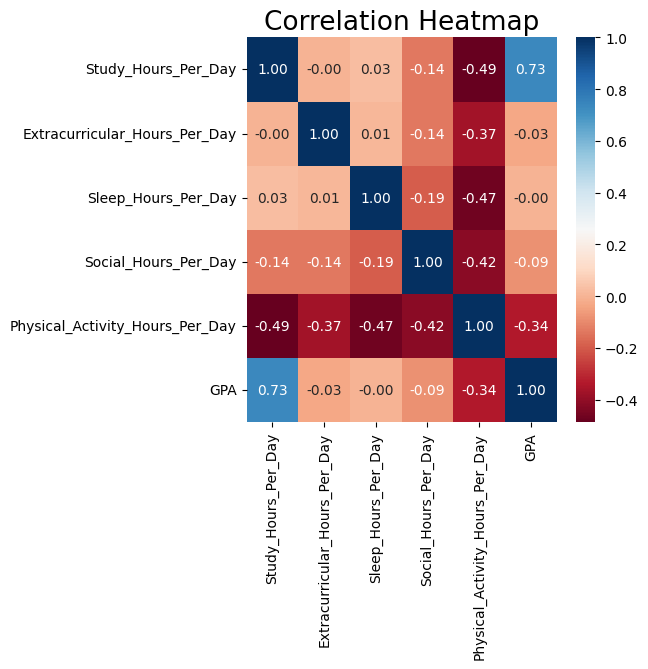

In [52]:
plt.figure(figsize=(5,5))

corr_matrix = df2.drop(columns=['Stress_Level', 'Stress_Encoded']).corr()

sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt='.2f')

plt.title('Correlation Heatmap', fontsize=19)
plt.show()

### Split & Train

In [53]:
X = df2.drop(columns = ['Stress_Level', 'Stress_Encoded'])
Y = df2['Stress_Level']

In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

### CatBoost

In [55]:
catboost_model = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, verbose=False, random_state=42)
catboost_model.fit(X_train, Y_train)

In [56]:
Y_pred = catboost_model.predict(X_test)
#Y_pred

In [57]:
accuracy = accuracy_score(Y_test, Y_pred)
accuracy

1.0

In [58]:
print(f'Accuracy: {accuracy:.4f}')
print(f'Percentage Accuracy: {accuracy*100}%')

Accuracy: 1.0000
Percentage Accuracy: 100.0%


### Deision Tree

In [59]:
tree_model = DecisionTreeClassifier(criterion = 'entropy', splitter = 'best', random_state = 42)
tree_model.fit(X_train, Y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [60]:
Y_pred = tree_model.predict(X_test)

In [61]:
accuracy = accuracy_score(Y_test, Y_pred)
accuracy

1.0

In [62]:
tree_model.score(X_test, Y_test)

1.0

In [63]:
print(f'Accuracy: {accuracy:.4f}')
print(f'Percentage Accuracy: {accuracy*100}%')

Accuracy: 1.0000
Percentage Accuracy: 100.0%


### Random Forest

In [64]:
forest_model = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state = 42)
forest_model.fit(X_train, Y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

In [65]:
Y_pred = forest_model.predict(X_test)

In [66]:
accuracy = accuracy_score(Y_test, Y_pred)
accuracy

1.0

In [67]:
forest_model.score(X_test, Y_test)

1.0

In [68]:
print(f'Accuracy: {accuracy:.4f}')
print(f'Percentage Accuracy: {accuracy*100}%')

Accuracy: 1.0000
Percentage Accuracy: 100.0%
